In [1]:
from cv2 import aruco
import cv2
import numpy as np
import matplotlib.pyplot as plt
import msgpack as mp
import msgpack_numpy as mpn
import os

from tqdm import tqdm
import csv

In [2]:
_pth = os.getcwd()
_pth = os.path.dirname(_pth)
_parent_folder = "cam_june_22_2023"
_calib_folder_name = "calibration_00"

_folder_name = "sk40_30_random_slow_00"
# _folder_name = "board"

_base_pth = os.path.join(_pth,"recorded_data",_parent_folder)

_webcam_calib_folder = os.path.join(_pth,"recorded_data",_parent_folder,_calib_folder_name)
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join( _webcam_calib_folder, "webcam_calibration.msgpack")

with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

_webcam_cam_mat

array([[671.25534529,   0.        , 678.00736213],
       [  0.        , 692.23316717, 443.37269229],
       [  0.        ,   0.        ,   1.        ]])

In [3]:
ARUCO_PARAMETERS = aruco.DetectorParameters_create()
ARUCO_DICT = aruco.Dictionary_get(aruco.DICT_ARUCO_ORIGINAL)
markerLength = 0.05
markerSeparation = 0.01

board = aruco.GridBoard_create(
        markersX=1,
        markersY=1,
        markerLength=markerLength,
        markerSeparation=markerSeparation,
        dictionary=ARUCO_DICT)

In [12]:
video_folders_pth = os.path.join(_base_pth)
video_folders_list = os.listdir(video_folders_pth)
video_folders_list = video_folders_list[2:]
video_folders_list

['sk40_30_4_random1',
 'sk40_30_4_random2',
 'sk40_30_5_random0',
 'sk40_30_random_slow_00']

In [27]:

default_ids = [0, 49, 80]
data = {"frame_id":[],"marker_ids":[], "corners":[], "tvec":[], "rvec":[]}

counter = 0

for _folder_name in video_folders_list:
    _video_pth = os.path.join(_base_pth,_folder_name,"webcam_color.msgpack")
    _video_file = open(_video_pth, "rb")
    _video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

    for _frame in tqdm(_video_data):

        shape = _frame.shape
        gray = cv2.cvtColor(_frame, cv2.COLOR_BGR2GRAY)
        corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, ARUCO_DICT, parameters=ARUCO_PARAMETERS)

        corners, ids, rejectedImgPoints, recoveredIds = aruco.refineDetectedMarkers(
            image = gray,
            board = board,
            detectedCorners = corners,
            detectedIds = ids,
            rejectedCorners = rejectedImgPoints,
            cameraMatrix = _webcam_cam_mat,
            distCoeffs = _webcam_dist)

        rotation_vectors, translation_vectors, _ = aruco.estimatePoseSingleMarkers(corners, 0.04, _webcam_cam_mat, _webcam_dist)

        if ids is None:
            data["frame_id"].append(counter)
            data["marker_ids"].append(None)
            data["corners"].append(None)
            data["tvec"].append(None)
            data["rvec"].append(None)

        if ids is not None:
            data["frame_id"].append(counter)
            data["marker_ids"].append(ids)
            data["corners"].append(corners)
            data["tvec"].append(translation_vectors)
            data["rvec"].append(rotation_vectors)

        counter+=1

    _video_file.close()

892it [00:15, 55.86it/s]


In [28]:
coordinate = {"0":{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              "49":{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              "80":{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]}}

doesnt_exist = [] # list of ids that doesnt exist in a frame

for i in range(len(data["frame_id"])):
    if data["marker_ids"][i] is not None:

        if default_ids[0] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[0])
        if default_ids[1] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[1])
        if default_ids[2] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[2])

        for j in range(len(data["marker_ids"][i])):
            if data["marker_ids"][i][j] in default_ids:
                coordinate[str(data["marker_ids"][i][j][0])]["x"].append(data["tvec"][i][j][0][0])
                coordinate[str(data["marker_ids"][i][j][0])]["y"].append(data["tvec"][i][j][0][1])
                coordinate[str(data["marker_ids"][i][j][0])]["z"].append(data["tvec"][i][j][0][2])
                coordinate[str(data["marker_ids"][i][j][0])]["rx"].append(data["rvec"][i][j][0][0])
                coordinate[str(data["marker_ids"][i][j][0])]["ry"].append(data["rvec"][i][j][0][1])
                coordinate[str(data["marker_ids"][i][j][0])]["rz"].append(data["rvec"][i][j][0][2])
        for k in doesnt_exist:
            coordinate[str(k)]["x"].append(np.nan)
            coordinate[str(k)]["y"].append(np.nan)
            coordinate[str(k)]["z"].append(np.nan)
            coordinate[str(k)]["rx"].append(np.nan)
            coordinate[str(k)]["ry"].append(np.nan)
            coordinate[str(k)]["rz"].append(np.nan)
        doesnt_exist = []
    else:
        for k in default_ids:
            coordinate[str(k)]["x"].append(np.nan)
            coordinate[str(k)]["y"].append(np.nan)
            coordinate[str(k)]["z"].append(np.nan)
            coordinate[str(k)]["rx"].append(np.nan)
            coordinate[str(k)]["ry"].append(np.nan)
            coordinate[str(k)]["rz"].append(np.nan)

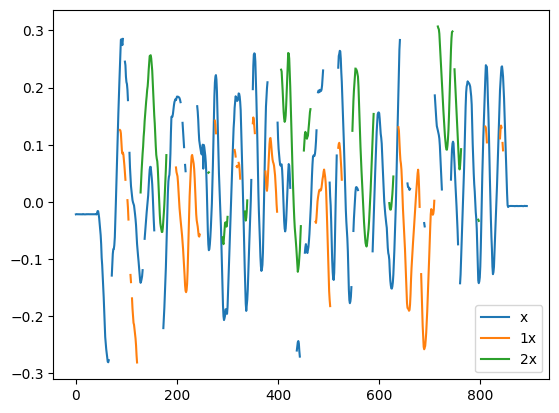

In [29]:
plt.plot(coordinate["0"]["x"], label="x")
plt.plot(coordinate["49"]["x"], label="1x")
plt.plot(coordinate["80"]["x"], label="2x")
plt.legend()

In [13]:
raw_data_pth = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
raw_data_pth = os.path.join(raw_data_pth, 'dataset',"multi_class", "raw_data")
if not os.path.exists(raw_data_pth):
    os.makedirs(os.path.join(raw_data_pth, "images"))
    os.makedirs(os.path.join(raw_data_pth, "labels"))

In [15]:
# based on the coordinate, we can create the labels
# we will create the labels for each frame


counter = 0
default_ids = [0, 49, 80]


for _folder_name in video_folders_list:

    doesnt_exist = [] # list of ids that doesnt exist in a frame
    _video_pth = os.path.join(_base_pth,_folder_name,"webcam_color.msgpack")
    _video_file = open(_video_pth, "rb")
    _video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)
    for _frame in tqdm(_video_data):

        shape = _frame.shape
        height, width, _ = shape
        gray = cv2.cvtColor(_frame, cv2.COLOR_BGR2GRAY)
        markerCorners, ids, rejectedImgPoints = aruco.detectMarkers(gray, ARUCO_DICT, parameters=ARUCO_PARAMETERS)

        markerCorners, ids, rejectedImgPoints, recoveredIds = aruco.refineDetectedMarkers(
            image = gray,
            board = board,
            detectedCorners = markerCorners,
            detectedIds = ids,
            rejectedCorners = rejectedImgPoints,
            cameraMatrix = _webcam_cam_mat,
            distCoeffs = _webcam_dist)

        if len(markerCorners) == 0:
            counter += 1
            continue

        img_name = f"image_{counter}.png"

        label_name = img_name.split(".")[0]
        label_path = os.path.join(raw_data_pth, "labels", f"{label_name}.txt")
        label_file = open(label_path, "w", newline='')
        label_writer = csv.writer(label_file, delimiter=" ")

        _class_name = "0"

        if default_ids[0] not in ids:
            doesnt_exist.append(default_ids[0])
        if default_ids[1] not in ids:
            doesnt_exist.append(default_ids[1])
        if default_ids[2] not in ids:
            doesnt_exist.append(default_ids[2])

        for i in range(len(ids)):
            _markerCorners = markerCorners[i][0]
            bbox_x,bbox_y,bbox_width,bbox_height = cv2.boundingRect(_markerCorners)

            bbox_x = bbox_x / width
            bbox_y = bbox_y / height

            bbox_center_x = bbox_x + bbox_width / (2 * width)
            bbox_center_y = bbox_y + bbox_height / (2 * height)

            bbox_width = bbox_width / width
            bbox_height = bbox_height / height
            if ids[i][0] == 0:
                _class_name = "0"
            elif ids[i][0] == 49:
                _class_name = "1"
            elif ids[i][0] == 80:
                _class_name = "2"

            label_writer.writerow([_class_name, bbox_center_x, bbox_center_y, bbox_width, bbox_height,_markerCorners[0][0]/width, _markerCorners[0][1]/height, _markerCorners[1][0]/width, _markerCorners[1][1]/height, _markerCorners[2][0]/width, _markerCorners[2][1]/height, _markerCorners[3][0]/width, _markerCorners[3][1]/height, _markerCorners[0][0]/width, _markerCorners[0][1]/height])


        label_file.close()
        doesnt_exist = []
        # save image
        image_path = os.path.join(raw_data_pth, "images", img_name)
        cv2.imwrite(image_path, _frame)
        counter += 1

    _video_file.close()

1044it [02:25,  7.20it/s]
848it [02:23,  5.90it/s]
403it [00:45,  8.92it/s]
892it [01:36,  9.21it/s]


In [17]:
# splitting dataset into train and validation and test
data_pth = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_pth = os.path.join(data_pth, 'dataset',"multi_class", "dataset_processed")

images_pth = os.path.join(data_pth, "images")
labels_pth = os.path.join(data_pth, "labels")

if not os.path.exists(images_pth):
    os.makedirs(os.path.join(images_pth, "train"))
    os.makedirs(os.path.join(images_pth, "val"))
    os.makedirs(os.path.join(images_pth, "test"))

if not os.path.exists(labels_pth):
    os.makedirs(os.path.join(labels_pth, "train"))
    os.makedirs(os.path.join(labels_pth, "val"))
    os.makedirs(os.path.join(labels_pth, "test"))
    
    
image_list = os.listdir(os.path.join(raw_data_pth, "images"))

# splitting dataset into train and test
for img_name in tqdm(image_list):
    
    _image_path = os.path.join(raw_data_pth, "images", img_name)
    image = cv2.imread(_image_path)
    
    label_name = img_name.split(".")[0]
    label_path = os.path.join(raw_data_pth, "labels", f"{label_name}.txt")
    label_file = open(label_path, "r", newline='')
    label_reader = csv.reader(label_file, delimiter=" ")
    label = list(label_reader)

    label_file.close()
    
    # if int(label[0]) == 0:
    if np.random.rand() < 0.7:
        # save image
        image_path = os.path.join(os.path.join(images_pth, "train"), img_name)
        cv2.imwrite(image_path, image)
        
        label_path = os.path.join(os.path.join(labels_pth, "train"), f"{label_name}.txt")
        label_file = open(label_path, "w", newline='')
        label_writer = csv.writer(label_file, delimiter=" ")
        for l in label:
            label_writer.writerow(l)
        label_file.close()
        
    elif np.random.rand() < 0.9 and np.random.rand() > 0.7:
        # save image
        image_path = os.path.join(os.path.join(images_pth, "val"), img_name)
        cv2.imwrite(image_path, image)
        
        label_path = os.path.join(os.path.join(labels_pth, "val"), f"{label_name}.txt")
        label_file = open(label_path, "w", newline='')
        label_writer = csv.writer(label_file, delimiter=" ")
        for l in label:
            label_writer.writerow(l)
        label_file.close()
        
    else:
        # save image
        image_path = os.path.join(os.path.join(images_pth, "test"), img_name)
        cv2.imwrite(image_path, image)
        
        label_path = os.path.join(os.path.join(labels_pth, "test"), f"{label_name}.txt")
        label_file = open(label_path, "w", newline='')
        label_writer = csv.writer(label_file, delimiter=" ")
        for l in label:
            label_writer.writerow(l)
        label_file.close() 


100%|██████████| 3127/3127 [03:58<00:00, 13.12it/s]
